In [45]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import featuretools as ft
import lightgbm as lgb
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

%matplotlib inline
RSEED = 50

# Load Original Features

In [96]:
feat_num = 454

In [97]:
df_total = pd.read_csv('./data/features%s.csv'%(feat_num))

In [98]:
features_train = df_total[df_total['isFraud'].notnull()]
features_test = df_total[df_total['isFraud'].isnull()]

In [99]:
labels_train = features_train['isFraud']
features_train = features_train.drop(columns = ['isFraud', 'TransactionID'])

In [100]:
features_train.shape

(590540, 452)

# Prepare model

In [101]:
categorical = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5','card6',
              'addr1','addr2','P_emaildomain','R_emaildomain','M1','M2','M3',
              'M4','M5','M6','M7','M8','M9','DeviceType','DeviceInfo','dow','hour',
              'card_id','Device_name','Device_version','screen_width','screen_height']
ids = [ 'id_%s'%(i) for i in range(12,39)]
categorical = categorical + ids

In [102]:
categorical = list(set(categorical).intersection(df_total.columns))

In [103]:
features_test_new = features_test.drop(columns = ['isFraud', 'TransactionID'])

In [113]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47,
          'scale_pos_weight':9
         }

In [93]:
params2 = {'num_leaves': 256,
          'min_child_samples': 79,
          'objective': 'binary',
          'max_depth': 13,
          'learning_rate': 0.03,
          "boosting_type": "gbdt",
          "subsample_freq": 3,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          'colsample_bytree': 0.9,
          #'categorical_feature': cat_cols
         }

# Feature Selection

In [105]:
train_set = lgb.Dataset(features_train, label=labels_train.values,
                       categorical_feature=categorical)
cv_results = lgb.cv(params, train_set, num_boost_round = 10000, metrics = 'auc',
                        early_stopping_rounds = 500, seed = RSEED, nfold = 5)
print('Cross Validation ROC AUC: {:.5f} with std: {:.5f}.'.format(cv_results['auc-mean'][-1],
                                                                               cv_results['auc-stdv'][-1]))


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Cross Validation ROC AUC: 0.97759 with std: 0.00182.


In [118]:
train_set = lgb.Dataset(features_train.iloc[0:472432,:], label=labels_train.values[0:472432],
                       categorical_feature=categorical)
valid_set = lgb.Dataset(features_train.iloc[472432:,:], label=labels_train.values[472432:],
                       categorical_feature=categorical)
model = lgb.train(params,train_set,num_boost_round = 10000, 
                   valid_sets = [train_set, valid_set],
                    verbose_eval=500,
                    early_stopping_rounds = 500)

/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.998745	valid_1's auc: 0.920995
[1000]	training's auc: 0.999878	valid_1's auc: 0.923699
[1500]	training's auc: 0.99999	valid_1's auc: 0.924608
[2000]	training's auc: 1	valid_1's auc: 0.925413
[2500]	training's auc: 1	valid_1's auc: 0.925582
Early stopping, best iteration is:
[2480]	training's auc: 1	valid_1's auc: 0.925589


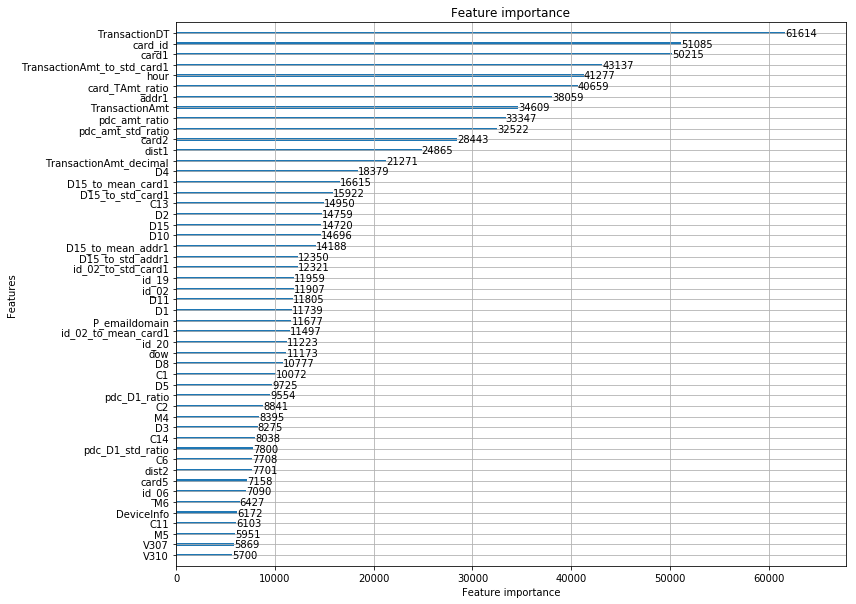

In [129]:
lgb.plot_importance(model, max_num_features=50,figsize=(12,10))

In [134]:
fi = pd.DataFrame({'feature': features_train.columns, 
                   'importance':model.feature_importance()})
fi = fi.sort_values('importance', ascending = False)

In [136]:
fi_important = fi.iloc[0:200,:]
features_train = features_train[fi_important.feature]
features_test_new = features_test[fi_important.feature]
categorical = list(set(categorical).intersection(fi_important.feature))

# Train Model

In [137]:
splits = 5
folds = KFold(n_splits = splits,random_state=RSEED)
predictions = np.zeros(len(features_test_new))

In [138]:
for fold_num, (trn_idx, val_idx) in enumerate(folds.split(features_train.values, 
                                                          labels_train.values)):
    print("Fold {}".format(fold_num))
    train_df, y_train_df = features_train.iloc[trn_idx], labels_train.iloc[trn_idx]
    valid_df, y_valid_df = features_train.iloc[val_idx], labels_train.iloc[val_idx]
    
    trn_data = lgb.Dataset(train_df, label=y_train_df,categorical_feature=categorical)
    val_data = lgb.Dataset(valid_df, label=y_valid_df,categorical_feature=categorical)
    
    clf = lgb.train(params,
                    trn_data,
                    10000,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=500,
                    early_stopping_rounds=500)

    pred = clf.predict(valid_df)
    print( "  auc = ", roc_auc_score(y_valid_df, pred) )
    predictions += clf.predict(features_test_new) / splits

Fold 0


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.998294	valid_1's auc: 0.904819
[1000]	training's auc: 0.999809	valid_1's auc: 0.911217
[1500]	training's auc: 0.999982	valid_1's auc: 0.914729
[2000]	training's auc: 0.999999	valid_1's auc: 0.916113
[2500]	training's auc: 1	valid_1's auc: 0.91702
[3000]	training's auc: 1	valid_1's auc: 0.917468
Early stopping, best iteration is:
[2688]	training's auc: 1	valid_1's auc: 0.917224
  auc =  0.9172240862012231
Fold 1


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.998673	valid_1's auc: 0.929785
[1000]	training's auc: 0.999874	valid_1's auc: 0.930637
[1500]	training's auc: 0.999992	valid_1's auc: 0.931488
[2000]	training's auc: 1	valid_1's auc: 0.932044
[2500]	training's auc: 1	valid_1's auc: 0.932312
Early stopping, best iteration is:
[2283]	training's auc: 1	valid_1's auc: 0.932296
  auc =  0.9322968969088619
Fold 2


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.998666	valid_1's auc: 0.924622
[1000]	training's auc: 0.999859	valid_1's auc: 0.925895
[1500]	training's auc: 0.99999	valid_1's auc: 0.926599
[2000]	training's auc: 1	valid_1's auc: 0.927149
[2500]	training's auc: 1	valid_1's auc: 0.927661
Early stopping, best iteration is:
[2449]	training's auc: 1	valid_1's auc: 0.927596
  auc =  0.9275964163479936
Fold 3


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.998753	valid_1's auc: 0.943883
[1000]	training's auc: 0.99987	valid_1's auc: 0.944942
[1500]	training's auc: 0.999989	valid_1's auc: 0.945503
[2000]	training's auc: 1	valid_1's auc: 0.946165
[2500]	training's auc: 1	valid_1's auc: 0.946538
[3000]	training's auc: 1	valid_1's auc: 0.946871
Early stopping, best iteration is:
[2510]	training's auc: 1	valid_1's auc: 0.946526
  auc =  0.9465262865912912
Fold 4


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.998701	valid_1's auc: 0.922008
[1000]	training's auc: 0.99987	valid_1's auc: 0.924323
[1500]	training's auc: 0.999989	valid_1's auc: 0.925541
[2000]	training's auc: 1	valid_1's auc: 0.925977
[2500]	training's auc: 1	valid_1's auc: 0.926173
[3000]	training's auc: 1	valid_1's auc: 0.926216
Early stopping, best iteration is:
[2598]	training's auc: 1	valid_1's auc: 0.926217
  auc =  0.9262173243950325


In [91]:
id_test = features_test['TransactionID']
submission = pd.DataFrame({'TransactionID': id_test, 
                            'isFraud': predictions})
submission.to_csv('./data/sub_feat%s_top200_modelselect.csv'%(feat_num), index = False)